In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import pickle  # Pour sauvegarder l'état de PCAx

# Matplotlib settings
from matplotlib import rcParams

# Scikit-learn modules
import pcax
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Keras (deep learning)
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.losses import MeanSquaredError, Huber, MeanAbsoluteError, LogCosh
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l1, l2, l1_l2
from pathlib import Path

# again, this only works on startup!
import jax
jax.config.update("jax_enable_x64", True)

2025-03-25 09:50:48.375797: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
import pcax  # Assure-toi que pcax est bien importé

# 📌 Chargement des simulations
data_path = Path("/Users/xifumacbook/Documents/Codes/Spectres/compTB/comptb_unconstrained_110.npz")  # Modifier selon ton répertoire
data = np.load(data_path)

# Extraction des simulations et des paramètres
spectres = data["simulations"]
theta = data["theta"]

# Suppression des colonnes non nécessaires dans theta (redshift, approx, norm)
theta = np.delete(theta, [1, -1], axis=1)  # Indices à adapter si besoin

# Vérification des dimensions
print(f"Theta shape : {theta.shape}")  # Paramètres
print(f"Spectrum shape : {spectres.shape}")  # Spectres simulés


# Transformation log des spectres
spectres = np.log1p(spectres)

# Normalisation sur l'ensemble des données
scaler_theta = StandardScaler()
scaler_spectre = RobustScaler()

#theta_scaled = scaler_theta.fit_transform(theta)
theta_scaled = theta
spectres_scaled = scaler_spectre.fit_transform(spectres)

# PCA sur les spectres normalisés
n_PCA = 20
pca_state = pcax.fit(spectres_scaled, n_components=n_PCA    )
spectres_pca = pcax.transform(pca_state, spectres_scaled)

# Division des données après transformations
X_train, X_test, y_train, y_test = train_test_split(theta_scaled, spectres_pca, test_size=0.1, random_state=42)

# Vérification post-split
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

# Variance expliquée par la PCA
explained_variance = np.sum(y_train.var(axis=0)) / np.sum(spectres_pca.var(axis=0))
print(f"Variance explained by the {n_PCA} first components : {explained_variance:.4%}")

# Calcul de la variance expliquée par composante
explained_variance_per_component = y_train.var(axis=0) / np.sum(y_train.var(axis=0))
cumulative_variance = np.cumsum(explained_variance_per_component)

# Plot de la variance expliquée
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_per_component) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.99, color='r', linestyle='--', label="99% de variance expliquée")
plt.xlabel("Nombre de PCA")
plt.ylabel("Variance expliquée cumulée")
plt.legend()
plt.show()


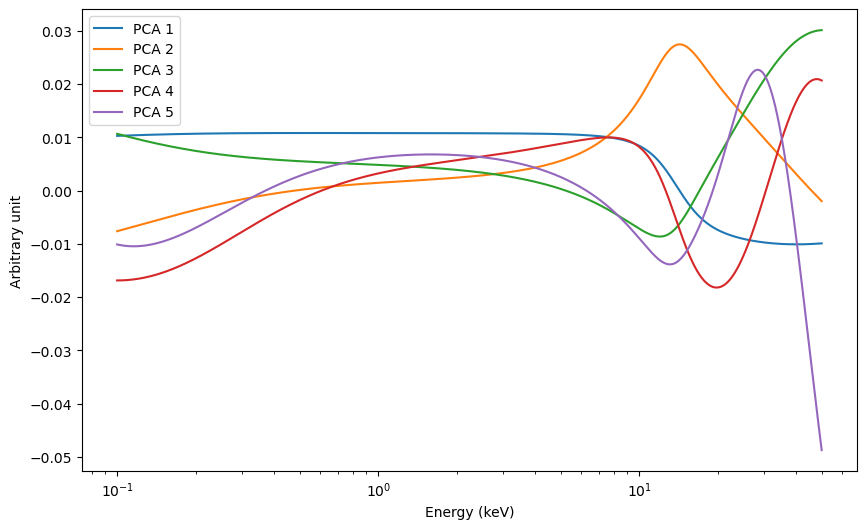

In [ ]:
# Définition de l'échelle d'énergie
e_min, e_max, num_bins = 0.1, 50, spectres.shape[1]  
energy_array = np.geomspace(e_min, e_max, num_bins)

# Récupération des 5 premières composantes PCA
pca_components = pca_state.components[:10, :]



# Tracé des 5 premières composantes en fonction de l'énergie
plt.figure(figsize=(10, 6))

for i in range(5):
    plt.plot(energy_array, pca_components[i], label=f'PCA {i+1}')

plt.xscale('log')
plt.xlabel("Energy (keV)")
plt.ylabel("Arbitrary unit")
plt.legend()
plt.show()


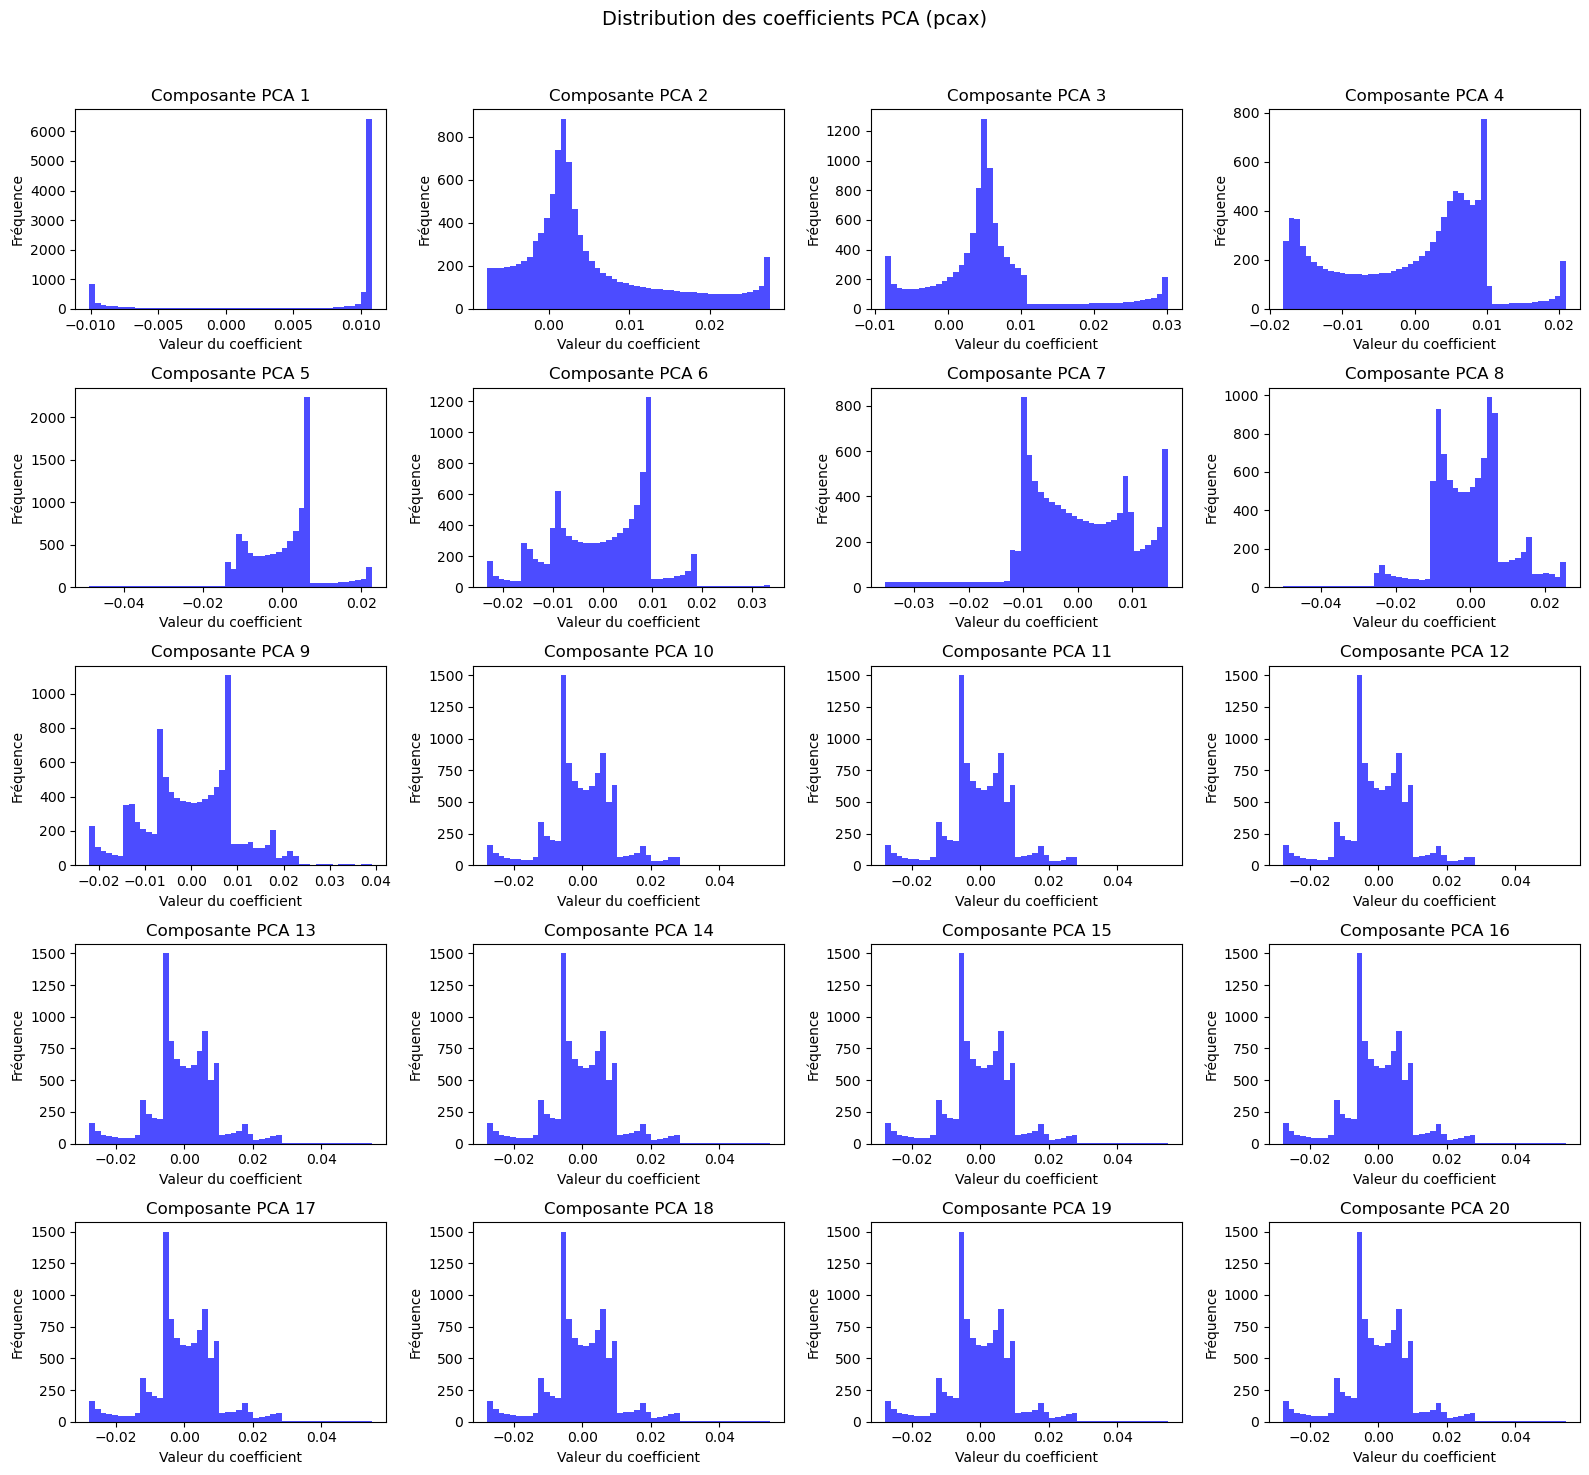

In [ ]:

# Détermination de la grille optimale (rows x cols)
n_rows = int(np.ceil(np.sqrt(n_PCA)))
n_cols = int(np.ceil(n_PCA / n_rows))

# Création des subplots dynamiquement
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 3))
fig.suptitle("Distribution des coefficients PCA (pcax)", fontsize=14)

# S'assurer que axes est toujours un tableau (utile si une seule ligne ou colonne)
axes = np.array(axes).reshape(n_rows, n_cols)

# Affichage des histogrammes
for i in range(n_PCA):
    row, col = divmod(i, n_cols)
    ax = axes[row, col]
    ax.hist(pca_components[i], bins=50, color='blue', alpha=0.7)
    ax.set_title(f"Composante PCA {i+1}")
    ax.set_xlabel("Valeur du coefficient")
    ax.set_ylabel("Fréquence")

# Supprime les axes inutilisés si la grille est plus grande que nécessaire
for i in range(n_PCA, n_rows * n_cols):
    row, col = divmod(i, n_cols)
    fig.delaxes(axes[row, col])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustement du layout
plt.show()


In [ ]:
# =======================
# Model Building
# =======================

def TBNN(input_dim, output_dim, learning_rate=1e-4):
    model = Sequential([
        Dense(256, activation='gelu', input_shape=(input_dim,)),
        Dense(256, activation='gelu'),
        Dense(256, activation='gelu'),
        Dense(256, activation='gelu'),
        #Dense(256, activation='gelu'),
        #Dense(256, activation='gelu'),
        Dense(output_dim, activation='linear')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=Huber(delta=5.5)
        #LogCosh()
        #MeanSquaredError
        #Huber(delta=1.35)  # Fonction de perte Huber
    )
    
    return model


input_dim = X_train.shape[1]    # Dimensions de theta après normalisation
output_dim = y_train.shape[1]   # Nombre de composantes PCA (déjà transformées)
model = TBNN(input_dim, output_dim)
model.summary()



# =======================
# Training
# =======================

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,  
    epochs=500,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


/Users/xifumacbook/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │         5,140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,052 (797.08 KB)

 Trainable params: 204,052 (797.08 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 2.8179 - val_loss: 0.5323 - learning_rate: 1.0000e-04
Epoch 2/500
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.4675 - val_loss: 0.3119 - learning_rate: 1.0000e-04
Epoch 3/500
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 0.2762 - val_loss: 0.2032 - learning_rate: 1.0000e-04
Epoch 4/500
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.1928 - val_loss: 0.1650 - learning_rate: 1.0000e-04
Epoch 5/500
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.1505 - val_loss: 0.1283 - learning_rate: 1.0000e-04
Epoch 6/500
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 0.1227 - val_loss: 0.1157 - learning_rate: 1.0000e-04
Epoch 7/500
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 0.1054 - val_loss: 0.0943 - learning_rate: 1.0000e-04
Epoch 8/500
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.0939 - val_loss: 0.0972 - learning_rate: 1.0000e-04
Epoch 9/500
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/st

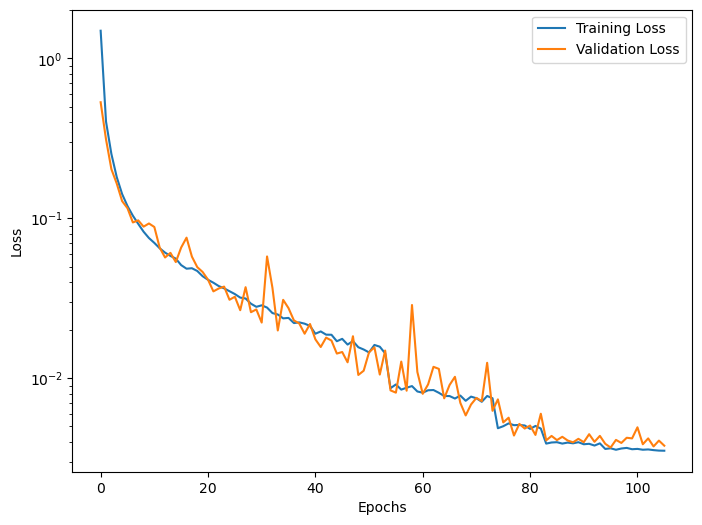

In [ ]:
# =======================
# Plotting Loss
# =======================

def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.show()

plot_loss(history)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 📌 **Reconstruction des spectres**
def reconstruct_spectra(pca_state, scaler_spectre, y_pca):
    y_scaled = pcax.recover(pca_state, y_pca)
    y_log = scaler_spectre.inverse_transform(y_scaled)
    return np.expm1(y_log)  # Conversion inverse du log1p

# 📌 **Analyse d'un échantillon spécifique**
def plot_sample(idx):
    theta_sample = X_test[idx:idx+1]  # Échantillon unique pour la prédiction

    # 📌 **Prédiction dans l'espace des PCA**
    spectrum_true_pca = y_test[idx]  # Maintenant `y_test` est déjà en PCA
    spectrum_pred_pca = model.predict(theta_sample)[0]

    # 📌 **Inversion de la PCA et du scaling**
    spectrum_true_orig = reconstruct_spectra(pca_state, scaler_spectre, spectrum_true_pca.reshape(1, -1)).flatten()
    spectrum_pred_orig = reconstruct_spectra(pca_state, scaler_spectre, spectrum_pred_pca.reshape(1, -1)).flatten()

    # 📌 **Calcul de l'erreur relative**
    eps = 1e-8
    error_bin = (spectrum_true_orig - spectrum_pred_orig) / (np.abs(spectrum_true_orig) + eps) * 100
    global_error = 100 * np.linalg.norm(spectrum_true_orig - spectrum_pred_orig) / np.linalg.norm(spectrum_true_orig)

    print(f"Sample {idx} | Relative overall error : {global_error:.3f}%")

    # 📌 **Création de l'échelle d'énergie**
    e_min, e_max, num_bins = 0.1, 50, spectrum_true_orig.shape[0]  
    energy_array = np.geomspace(e_min, e_max, num_bins)

    # 📌 **Récupération des paramètres originaux**
    theta_orig = X_test[idx]
    
    # Noms des paramètres avec notation mathématique (ajustés pour le modèle comptb)
    param_names = [r"$kT_s$", r"$\alpha$", r"$\delta$", r"$kT_e$", r"$\log(A)$"]

    # 📌 **Affichage des paramètres**
    print("Parameters used for the sample:")
    for name, value in zip(param_names, theta_orig):
        print(f" - {name}: {value:.4f}")

    param_str = ", ".join([f"{name}={value:.3f}" for name, value in zip(param_names, theta_orig)])

    # 📌 **Affichage des résultats**
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True)
    
    # **Comparaison des spectres**
    ax1.semilogx(energy_array, spectrum_pred_orig, label='Reconstructed spectrum', color='blue')
    ax1.semilogx(energy_array, spectrum_true_orig, label='Original spectrum', color='red', linestyle="dashed")
    ax1.set_ylabel("Intensity")
    ax1.set_xlabel("Energy (keV)")
    ax1.legend()
    ax1.set_title(f"Sample {idx}\n{param_str}", fontsize=10)

    # **Erreur relative**
    ax2.plot(energy_array, error_bin, label="Relative error (%)", color='red')
    ax2.fill_between(energy_array, 0, error_bin, color='red', alpha=0.3)
    ax2.set_xlabel("Energy (keV)")
    ax2.set_ylabel("Error (%)")
    ax2.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# # Reconstruction des spectres
# def reconstruct_spectra(pca_state, scaler_spectre, y_pca):
#     y_scaled = pcax.recover(pca_state, y_pca)
#     y_log = scaler_spectre.inverse_transform(y_scaled)
#     return np.expm1(y_log)  # Conversion inverse du log1p

# # Analyse d'un échantillon spécifique
# def plot_sample(idx):
#     theta_sample = X_test[idx:idx+1]  # Échantillon unique pour la prédiction

#     # Prédiction dans l'espace des PCA
#     spectrum_true = y_test[idx]
#     spectrum_pred = model.predict(theta_sample)[0]

#     # Inversion de la PCA et du scaling
#     spectrum_true_orig = reconstruct_spectra(pca_state, scaler_spectre, spectrum_true.reshape(1, -1)).flatten()
#     spectrum_pred_orig = reconstruct_spectra(pca_state, scaler_spectre, spectrum_pred.reshape(1, -1)).flatten()

#     # Calcul de l'erreur relative
#     eps = 1e-8
#     error_bin = (spectrum_true_orig - spectrum_pred_orig) / (np.abs(spectrum_true_orig) + eps) * 100
#     global_error = 100 * np.linalg.norm(spectrum_true_orig - spectrum_pred_orig) / np.linalg.norm(spectrum_true_orig)

#     print(f"Sample {idx} | Relative overall error : {global_error:.3f}%")

#     # Création de l'échelle d'énergie
#     e_min, e_max, num_bins = 0.1, 50, spectres.shape[1]  
#     energy_array = np.geomspace(e_min, e_max, num_bins)

#     # Récupération des paramètres originaux
#     theta_orig = X_test
#     #theta_orig = scaler_theta.inverse_transform(X_test)
#     params = theta_orig[idx]

#     # Noms des paramètres avec notation mathématique
#     param_names = [r"$kT_s$", r"$\Gamma$", r"$\alpha$", r"$\delta$", r"$kT_e$", r"$\log(A)$"]

#     # Affichage des paramètres dans la console avec format LaTeX
#     print("Parameters used for the sample:")
#     for name, value in zip(param_names, params):
#         print(f" - {name}: {value:.4f}")

#     # Construction du titre avec les paramètres en LaTeX
#     param_str = ", ".join([f"{name}={value:.3f}" for name, value in zip(param_names, params)])

#     # Affichage des résultats
#     fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True)
    
#     # Comparaison des spectres
#     ax1.semilogx(energy_array, spectrum_pred_orig, label='Reconstructed spectrum', color='blue')
#     ax1.semilogx(energy_array, spectrum_true_orig, label='Original spectrum', color='red', linestyle="dashed")
#     ax1.set_ylabel("Intensity")
#     ax1.set_xlabel("Energy (keV)")
#     ax1.legend()
#     ax1.set_title(f"Sample {idx}\n{param_str}", fontsize=10)

#     # Erreur relative
#     ax2.plot(energy_array, error_bin, label="Relative error (%)", color='red')
#     ax2.fill_between(energy_array, 0, error_bin, color='red', alpha=0.3)
#     ax2.set_xlabel("Energy (keV)")
#     ax2.set_ylabel("Error (%)")
#     ax2.legend()

#     plt.tight_layout()
#     plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Sample 2234 | Relative overall error : 3.822%
Parameters used for the sample:
 - $kT_s$: 3.6448
 - $\alpha$: 1.5002
 - $\delta$: 1.1647
 - $kT_e$: 1.0764
 - $\log(A)$: 1.2249


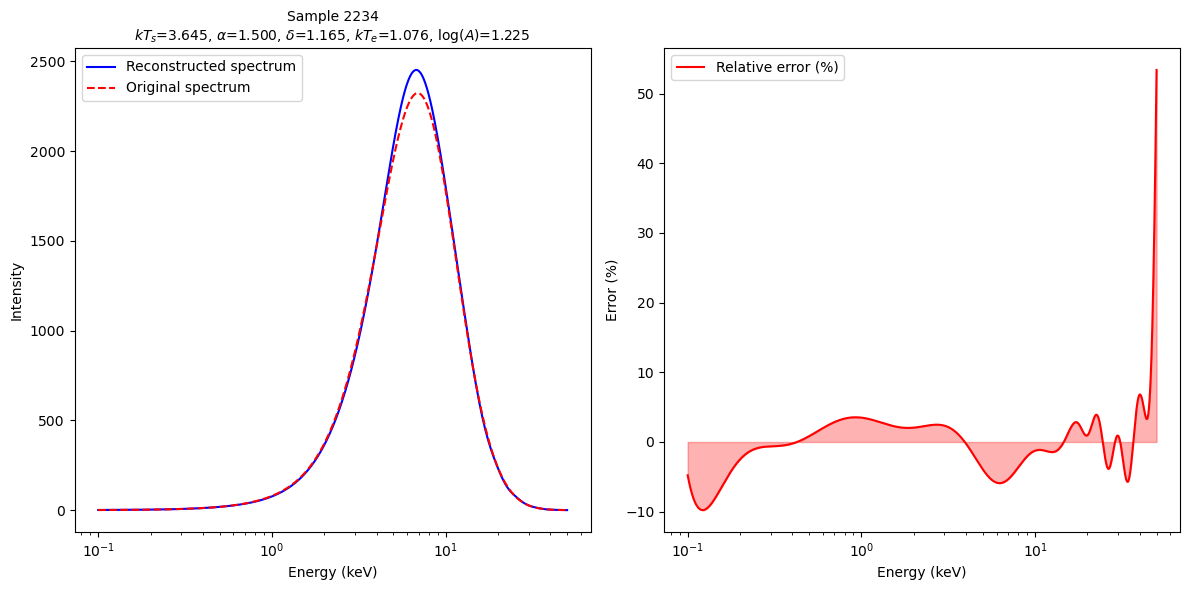

In [ ]:
plot_sample(2234)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
X_test shape: (5000, 5)
Global_errors shape: (5000,)

 Nombre de spectres avec une erreur > 3% : 12
Indices des spectres concernés : [ 245  266  551  572 1124 1564 1596 1627 2158 2234 3191 3364]

 Spectre avec l'erreur maximale : Index 245
   - Erreur : 13.153%
   - Paramètres associés :
     $kT_s$: 7.8717
     $\alpha$: 1.2255
     $\delta$: 1.2814
     $kT_e$: 1.0312
     $\log(A)$: 0.1537


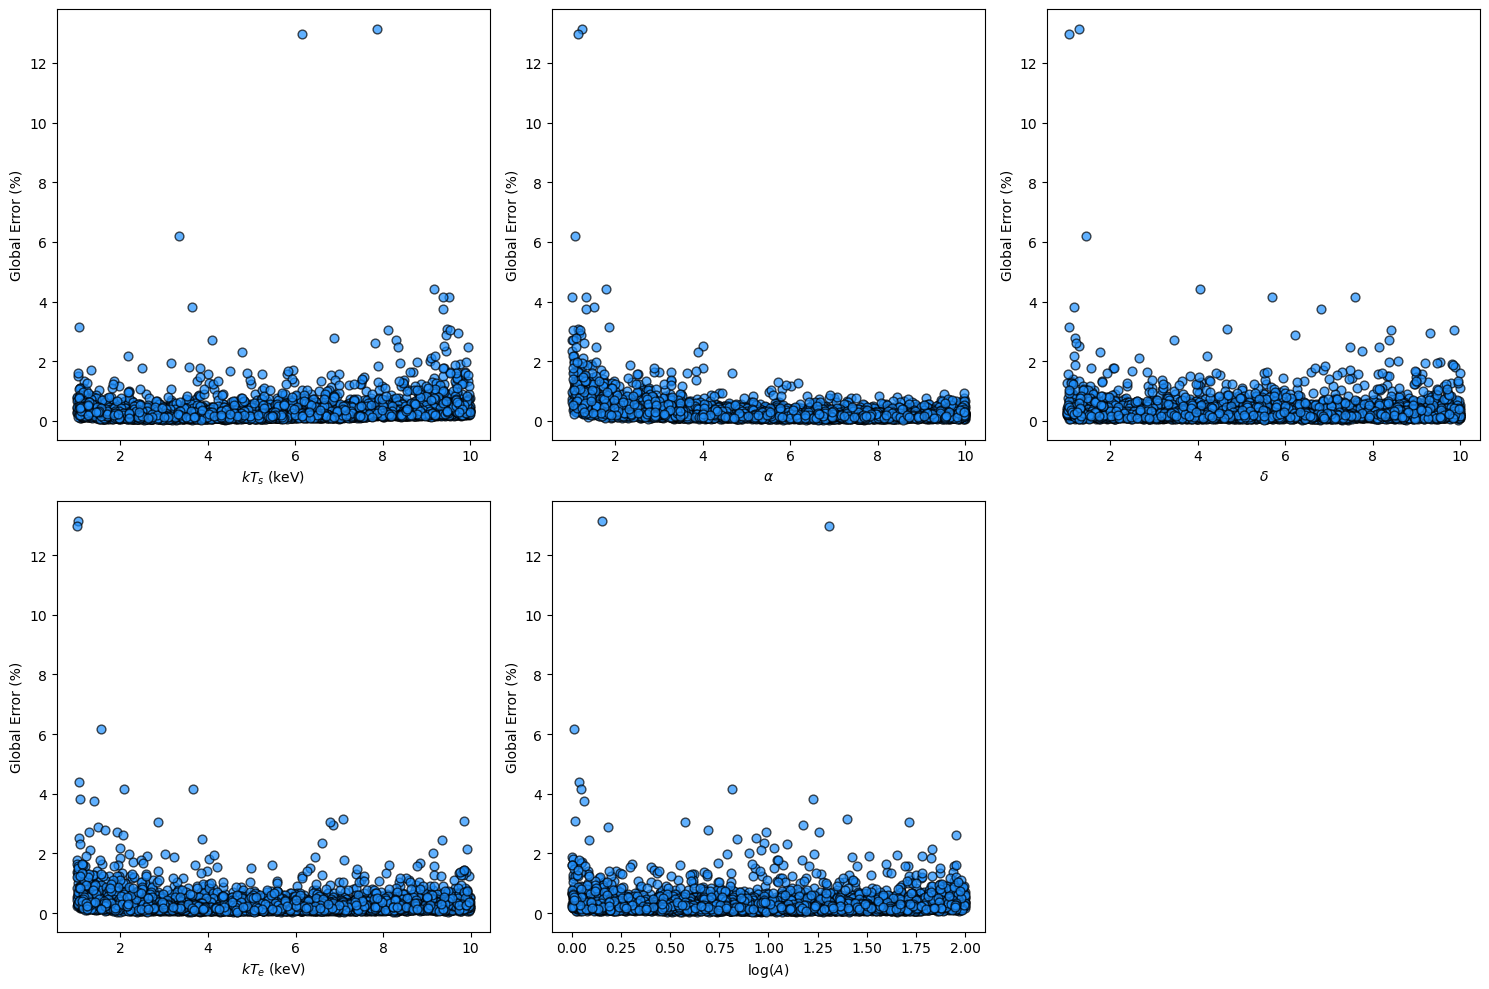


 Indices des spectres avec erreur > 3% : [ 245  266  551  572 1124 1564 1596 1627 2158 2234 3191 3364]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Fonction pour reconstruire les spectres à partir des PCA
def reconstruct_spectra(pca_state, scaler_spectre, y_pca):
    y_scaled = pcax.recover(pca_state, y_pca)
    y_log = scaler_spectre.inverse_transform(y_scaled)
    return np.expm1(y_log)  # Conversion inverse du log1p

def plot_global_errors_per_theta(model, X_test, y_test, pca_state, pcax, scaler_spectre, custom_legends=None):
    """
    Trace les erreurs globales pour chaque spectre en fonction des 5 paramètres theta,
    et identifie les spectres avec une erreur > 3%.
    """

    eps = 1e-8

    # Prédictions du modèle
    y_pred_pca = model.predict(X_test)

    # Reconstruction des spectres à partir des PCA
    y_test_orig = reconstruct_spectra(pca_state, scaler_spectre, y_test)
    y_pred_orig = reconstruct_spectra(pca_state, scaler_spectre, y_pred_pca)

    # Calcul des erreurs globales (identique à plot_sample)
    global_errors = [
        100 * np.linalg.norm(true_spectrum - pred_spectrum) / np.linalg.norm(true_spectrum + eps)
        for true_spectrum, pred_spectrum in zip(y_test_orig, y_pred_orig)
    ]

    global_errors = np.array(global_errors)

    # Vérifier les formes
    print(f"X_test shape: {X_test.shape}")
    print(f"Global_errors shape: {global_errors.shape}")

    # Trouver les indices des spectres avec erreur > 3%
    high_error_indices = np.where(global_errors > 3)[0]
    num_high_errors = len(high_error_indices)

    # Afficher les résultats
    print(f"\n Nombre de spectres avec une erreur > 3% : {num_high_errors}")
    if num_high_errors > 0:
        print(f"Indices des spectres concernés : {high_error_indices}")

    # Transformation inverse des paramètres theta
    theta_orig = X_test

    # Vérification : Afficher les paramètres du pire spectre
    if num_high_errors > 0:
        worst_idx = np.argmax(global_errors)  # Trouver le spectre avec l'erreur maximale
        print(f"\n Spectre avec l'erreur maximale : Index {worst_idx}")
        print(f"   - Erreur : {global_errors[worst_idx]:.3f}%")

        # Mise à jour des paramètres (suppression de `gamma` et `norm`)
        theta_names = [r"$kT_s$", r"$\alpha$", r"$\delta$", r"$kT_e$", r"$\log(A)$"]

        print(f"   - Paramètres associés :")
        for name, value in zip(theta_names, theta_orig[worst_idx]):
            print(f"     {name}: {value:.4f}")

    # Tracer les erreurs par paramètre
    plt.figure(figsize=(15, 10))
    theta_names = [r"$kT_s$", r"$\alpha$", r"$\delta$", r"$kT_e$", r"$\log(A)$"]  # Mise à jour ici

    for i, param_name in enumerate(theta_names):
        plt.subplot(2, 3, i + 1)
        plt.scatter(theta_orig[:, i], global_errors, color='dodgerblue', alpha=0.7, edgecolor='black', s=40)

        # Utiliser les légendes personnalisées si elles sont fournies
        xlabel = custom_legends[param_name]["xlabel"] if custom_legends and param_name in custom_legends else param_name
        ylabel = custom_legends[param_name]["ylabel"] if custom_legends and param_name in custom_legends else "Global Error (%)"

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    
    plt.tight_layout()
    plt.show()

    return high_error_indices  # Retourne les indices des spectres avec erreur > 3%

# Exemple d'utilisation avec des légendes personnalisées (mis à jour sans `gamma` et `norm`)
custom_legends = {
    r"$kT_s$": {"xlabel": r"$kT_s$ (keV)", "ylabel": "Global Error (%)"},
    r"$\alpha$": {"xlabel": r"$\alpha$", "ylabel": "Global Error (%)"},
    r"$\delta$": {"xlabel": r"$\delta$", "ylabel": "Global Error (%)"},
    r"$kT_e$": {"xlabel": r"$kT_e$ (keV)", "ylabel": "Global Error (%)"},
    r"$\log(A)$": {"xlabel": r"$\log(A)$", "ylabel": "Global Error (%)"},
}

# Appel de la fonction et récupération des indices
high_error_indices = plot_global_errors_per_theta(
    model=model,
    X_test=X_test,
    y_test=y_test,  # On passe directement les données PCA comme dans plot_sample()
    pca_state=pca_state,
    pcax=pcax,
    scaler_spectre=scaler_spectre,
    custom_legends=custom_legends
)

print(f"\n Indices des spectres avec erreur > 3% : {high_error_indices}")


Theta shape : (50000, 5)
Spectrum shape : (50000, 10000)
X_train shape: (45000, 5), X_test shape: (5000, 5)
y_train shape: (45000, 20), y_test shape: (5000, 20)
Variance explained by the 20 first components : 0.0005%


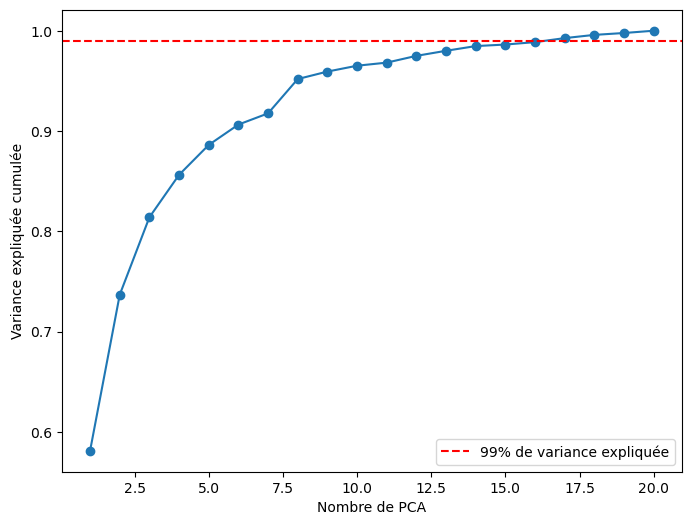

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import pcax  # Assure-toi que pcax est bien importé

# 📌 Chargement des simulations
data_path = Path("/Users/xifumacbook/Documents/Codes/Spectres/compTB/comptb_unconstrained_110.npz")  # Modifier selon ton répertoire
data = np.load(data_path)

# Extraction des simulations et des paramètres
spectres = data["simulations"]
theta = data["theta"]

# Suppression des colonnes non nécessaires dans theta (redshift, approx, norm)
theta = np.delete(theta, [1, -1], axis=1)  # Indices à adapter si besoin

# Vérification des dimensions
print(f"Theta shape : {theta.shape}")  # Paramètres
print(f"Spectrum shape : {spectres.shape}")  # Spectres simulés

#spectres = np.random.poisson(lam=np.abs(spectres))

# Transformation log des spectres
spectres = np.log1p(spectres)

# Normalisation sur l'ensemble des données
scaler_theta = RobustScaler()
scaler_spectre = MinMaxScaler()

#theta_scaled = scaler_theta.fit_transform(theta)
theta_scaled = theta
#spectres_scaled = scaler_spectre.fit_transform(spectres)

# PCA sur les spectres normalisés
n_PCA = 20
pca_state = pcax.fit(spectres, n_components=n_PCA    )
spectres_pca = pcax.transform(pca_state, spectres)

spectres_scaled = scaler_spectre.fit_transform(spectres_pca)

# Division des données après transformations
X_train, X_test, y_train, y_test = train_test_split(theta_scaled, spectres_scaled, test_size=0.1, random_state=42)

# Vérification post-split
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

# Variance expliquée par la PCA
explained_variance = np.sum(y_train.var(axis=0)) / np.sum(spectres_pca.var(axis=0))
print(f"Variance explained by the {n_PCA} first components : {explained_variance:.4%}")

# Calcul de la variance expliquée par composante
explained_variance_per_component = y_train.var(axis=0) / np.sum(y_train.var(axis=0))
cumulative_variance = np.cumsum(explained_variance_per_component)

# Plot de la variance expliquée
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_per_component) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.99, color='r', linestyle='--', label="99% de variance expliquée")
plt.xlabel("Nombre de PCA")
plt.ylabel("Variance expliquée cumulée")
plt.legend()
plt.show()


/Users/xifumacbook/miniforge3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │         5,140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,052 (797.08 KB)

 Trainable params: 204,052 (797.08 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0489 - val_loss: 0.0016 - learning_rate: 1.0000e-04
Epoch 2/500
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0014 - val_loss: 0.0010 - learning_rate: 1.0000e-04
Epoch 3/500
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 9.4363e-04 - val_loss: 8.1285e-04 - learning_rate: 1.0000e-04
Epoch 4/500
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 7.6482e-04 - val_loss: 6.8525e-04 - learning_rate: 1.0000e-04
Epoch 5/500
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.7411e-04 - val_loss: 6.2210e-04 - learning_rate: 1.0000e-04
Epoch 6/500
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.0331e-04 - val_loss: 5.6061e-04 - learning_rate: 1.0000e-04
Epoch 7/500
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 5.3581e-04 - val_loss: 5.1017e-04 - learning_rate: 1.0000e-04
Epoch 8/500
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 5.0157e-04 - val_loss: 5.0084e-04 - learning_rate: 1.0000e-04
Epoch 9/500
317/317 ━━━━━━━━━━

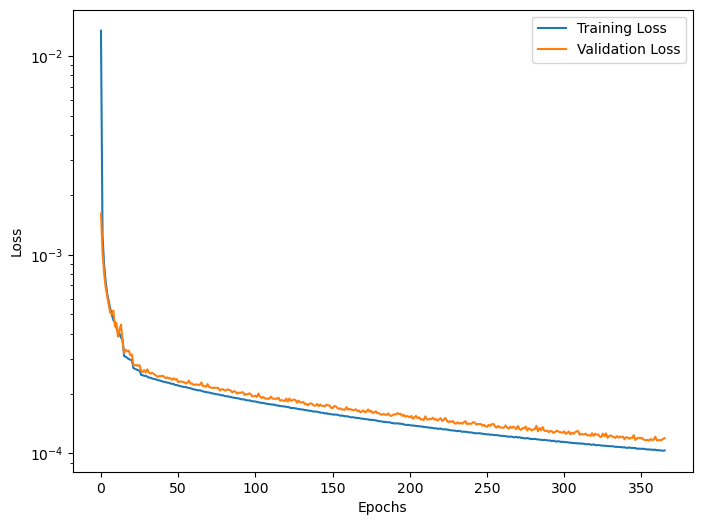

In [4]:
# 📌 **Définition du modèle de réseau de neurones**
def TBNN(input_dim, output_dim, learning_rate=1e-4):
    model = Sequential([
        Dense(256, activation='selu', input_shape=(input_dim,)),
        Dense(256, activation='selu'),
        Dense(256, activation='selu'),
        Dense(256, activation='selu'),
        #Dense(256, activation='gelu'),
        #Dense(256, activation='gelu'),
        Dense(output_dim, activation='linear')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=#MeanSquaredError
        Huber(delta=1.35)  # Fonction de perte Huber
    )
    
    return model

# 📌 **Détermination des dimensions d'entrée et sortie**
input_dim = X_train.shape[1]    # Dimensions de theta après normalisation
output_dim = y_train.shape[1]   # Nombre de composantes PCA (déjà transformées)

# 📌 **Construction et résumé du modèle**
model = TBNN(input_dim, output_dim)
model.summary()

# 📌 **Définition des callbacks**
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

# 📌 **Entraînement du modèle**
history = model.fit(
    X_train, y_train,
    validation_split=0.1,  
    epochs=500,
    batch_size=128,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# 📌 **Évolution de la loss**
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.show()

plot_loss(history)

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 📌 **Reconstruction des spectres**
def reconstruct_spectra(pca_state, scaler_spectre, y_scaled):
    """
    Inverse d'abord le scaler (appliqué après la PCA), puis la PCA,
    et enfin la transformation log1p.
    """
    y_pca = scaler_spectre.inverse_transform(y_scaled)            # 🔄 1. Annulation du Standard Scaler
    y_log = pcax.recover(pca_state, y_pca)                        # 🔄 2. Annulation de la PCA
    return np.expm1(y_log)                                        # 🔄 3. Annulation du log1p

# 📌 **Analyse d'un échantillon spécifique**
def plot_sample(idx):
    theta_sample = X_test[idx:idx+1]  # Échantillon unique pour la prédiction

    # 📌 **Prédiction dans l'espace du SCALER**
    spectrum_true_scaled = y_test[idx]                          # `y_test` est déjà SCALÉ
    spectrum_pred_scaled = model.predict(theta_sample)[0]

    # 📌 **Reconstruction complète vers l'espace d'origine**
    spectrum_true_orig = reconstruct_spectra(pca_state, scaler_spectre, spectrum_true_scaled.reshape(1, -1)).flatten()
    spectrum_pred_orig = reconstruct_spectra(pca_state, scaler_spectre, spectrum_pred_scaled.reshape(1, -1)).flatten()

    # 📌 **Calcul de l'erreur relative par bin**
    eps = 1e-8
    error_bin = (spectrum_true_orig - spectrum_pred_orig) / (np.abs(spectrum_true_orig) + eps) * 100
    global_error = 100 * np.linalg.norm(spectrum_true_orig - spectrum_pred_orig) / np.linalg.norm(spectrum_true_orig)

    print(f"Sample {idx} | Relative overall error : {global_error:.3f}%")

    # 📌 **Échelle d'énergie (logarithmique)**
    e_min, e_max, num_bins = 0.1, 50, spectrum_true_orig.shape[0]
    energy_array = np.geomspace(e_min, e_max, num_bins)

    # 📌 **Récupération des paramètres d'entrée**
    theta_orig = X_test[idx]
    param_names = [r"$kT$"]  # Tu adaptes ici si plus de paramètres

    # 📌 **Affichage des paramètres**
    print("Parameters used for the sample:")
    for name, value in zip(param_names, theta_orig):
        print(f" - {name}: {value:.4f}")

    param_str = ", ".join([f"{name}={value:.3f}" for name, value in zip(param_names, theta_orig)])

    # 📌 **Plot des résultats**
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

    ax1.semilogx(energy_array, spectrum_pred_orig, label='Reconstructed spectrum', color='blue')
    ax1.semilogx(energy_array, spectrum_true_orig, label='Original spectrum', color='red', linestyle="dashed")
    ax1.set_ylabel("Intensity")
    ax1.set_xlabel("Energy (keV)")
    ax1.legend()
    ax1.set_title(f"Sample {idx}\n{param_str}", fontsize=10)

    ax2.plot(energy_array, error_bin, label="Relative error (%)", color='red')
    ax2.fill_between(energy_array, 0, error_bin, color='red', alpha=0.3)
    ax2.set_xlabel("Energy (keV)")
    ax2.set_ylabel("Error (%)")
    ax2.legend()

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Sample 35 | Relative overall error : 3.734%
Parameters used for the sample:
 - $kT$: 5.0022


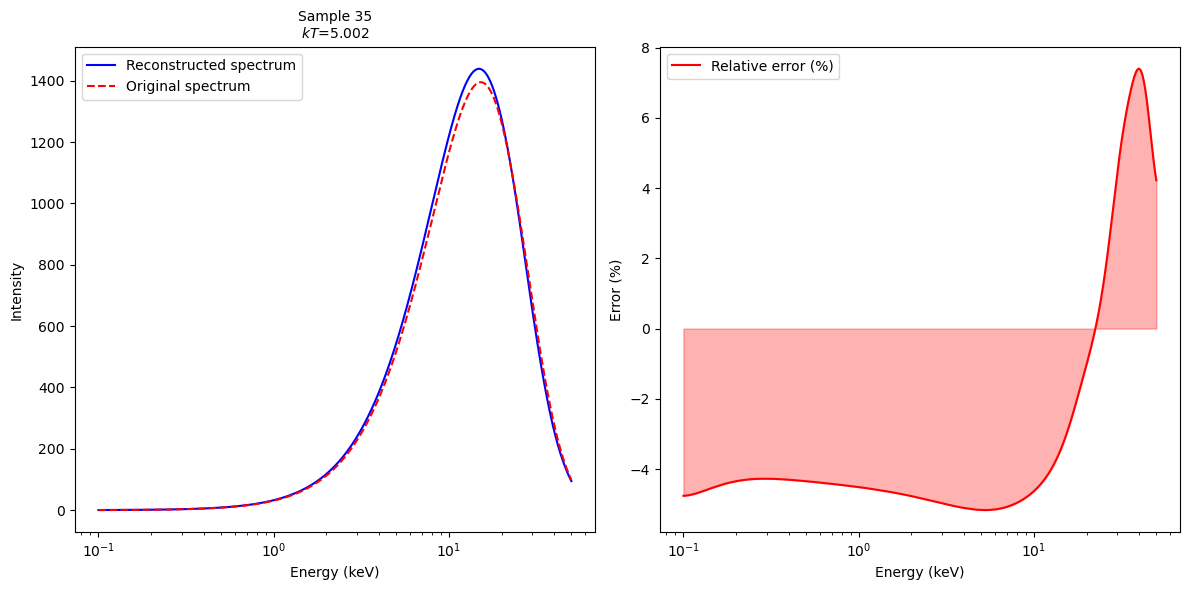

In [6]:
plot_sample(35)